That last notebook got messy so I'm making a new cleaner one that will enable me to sample over both emulators simultaneously. 

In [1]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
#from corner import corner
from ast import literal_eval
from pearce.emulator import LemonPepperWet
from os import path
from scipy.linalg import inv

 /u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


In [3]:
fname = '/u/ki/swmclau2/des/PearceMCMC/HOD_wp_ds_rmin_None_HSAB.hdf5'

In [4]:
f = h5py.File(fname, 'r')

In [5]:
tf = f.attrs['training_file']
fixed_params = literal_eval(f.attrs['fixed_params'])
if 'rmin' in fixed_params:
    del fixed_params['rmin']
emu_hps = literal_eval(f.attrs['emu_hps'])

In [6]:
tf

array(['/u/ki/swmclau2/des/Aemulators/wp_hsab_h/PearceWpHSABCosmo.hdf5',
       '/u/ki/swmclau2/des/Aemulators/ds_hsab_h/PearceHSABDsCosmo.hdf5'],
      dtype='|S62')

In [7]:
emus = []
for t in tf:
    print t
    emus.append(LemonPepperWet(t, fixed_params = fixed_params, hyperparams = emu_hps) )

/u/ki/swmclau2/des/Aemulators/wp_hsab_h/PearceWpHSABCosmo.hdf5
/u/ki/swmclau2/des/Aemulators/ds_hsab_h/PearceHSABDsCosmo.hdf5


In [8]:
chain_pnames = f.attrs['param_names']

In [9]:
n_walkers = f.attrs['nwalkers']

In [10]:
n_burn = 1000
chain = f['chain'][n_burn*n_walkers:, :]

In [11]:
rmin = 0#eval(f.attrs['fixed_params'])['rmin']

In [12]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [13]:
print chain.shape, chain.shape[0]/n_walkers

(3288250, 14) 13153


In [14]:
c = ChainConsumer()
chain = chain.reshape((-1, n_walkers, chain.shape[1]))
chain = chain.reshape((-1, chain.shape[2]), order = 'F')
c.add_chain(chain, parameters=list(chain_pnames), walkers = n_walkers)


In [15]:
#MAP = chain.mean(axis = 0)
summary = c.analysis.get_summary(chains=0)
MAP = np.array([summary[key][1] for key in chain_pnames])
print MAP

[ 2.36316016e-02  1.01314076e-01 -5.68052721e-01  9.28064755e-01
  7.47330110e+01  4.27436519e+00  6.83956430e-01 -9.93713208e-01
  1.26031380e+01  1.01569366e-01 -9.93721902e-01  1.39186289e+01
  1.01736670e+00  1.69489782e+00]


In [16]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8',
       'mean_occupation_centrals_assembias_param1', 'logM0', 'sigma_logM',
       'mean_occupation_satellites_assembias_param1', 'logM1', 'alpha',
       'conc_gal_bias'], dtype='|S43')

In [17]:
MAP_dict = dict(zip(chain_pnames, MAP))

In [18]:
#fixed_params = eval(f.attrs['chain_fixed_params'])
#fixed_params.update(eval(f.attrs['sim'])['cosmo_params'])

In [19]:
MAP_dict.update(fixed_params)

In [20]:
MAP_dict

{'H0': 74.73301099932365,
 'Neff': 4.274365194106216,
 'alpha': 1.0173666967245902,
 'conc_gal_bias': 1.6948978162835004,
 'logM0': 12.603138022445606,
 'logM1': 13.91862889546228,
 'mean_occupation_centrals_assembias_param1': -0.9937132077924373,
 'mean_occupation_satellites_assembias_param1': -0.9937219018000736,
 'ns': 0.9280647554180839,
 'ombh2': 0.023631601608791557,
 'omch2': 0.10131407552287339,
 'sigma8': 0.6839564295062823,
 'sigma_logM': 0.10156936633387251,
 'w0': -0.5680527207954078,
 'z': 0.0}

In [21]:
MAP_pred = np.hstack([emu.emulate_wrt_r(MAP_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
MAP_pred = MAP_pred.reshape((len(emus), -1))

In [22]:
hod_idxs = np.array(range(7, len(chain_pnames)))
cosmo_idxs = np.array(range(7))

In [23]:
if chain.shape[1] == 7:
    cosmo_chain = chain
else:
    hod_chain = chain[:,7:]#[:, hod_idxs]
    cosmo_chain = chain[:,:7]#[:, cosmo_idxs]

In [24]:
from pearce.mocks import cat_dict
cosmo_params = {}

In [25]:
cosmo_params['boxno'] = 1
cosmo_params['realization'] = 1

In [26]:
cat = cat_dict['testbox'](**cosmo_params)#construct the specified catalog!

In [27]:
h = 0.6777
cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']
cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2-0.048206*h**2,\
                            -1, 0.9667, \
                                h*100, 3.046, 0.8228]) #mdpl2

cat_val_dict = dict(zip(cosmo_pnames, cosmo_true_vals))

In [28]:
cat_val_dict

{'H0': 67.77,
 'Neff': 3.046,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'w0': -1.0}

In [29]:
true_param_dict = cat_val_dict.copy()
hod_params = {'alpha': 1.083, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.2, 'sigma_logM': 0.2}#sim_info['hod_params']
#hod_params = {'alpha': 0.95, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.5, 'sigma_logM': 0.2}#sim_info['hod_params']


hod_params['mean_occupation_centrals_assembias_param1'] = 0.0
hod_params['mean_occupation_satellites_assembias_param1'] =0.0
#hod_params['mean_occupation_centrals_assembias_slope1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_slope1'] = 0.0

#for pname in emu.get_param_names():
#    if 'mean_occupation' in pname:
#        hod_params[pname] = 0.0

for hp, hv in hod_params.iteritems():
    if hp == 'logMmin':
        continue
    true_param_dict[hp] = hv

true_param_dict['conc_gal_bias'] = 1.0
true_pred = emu.emulate_wrt_r(true_param_dict)[0]

In [30]:
true_param_dict

{'H0': 67.77,
 'Neff': 3.046,
 'alpha': 1.083,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.2,
 'mean_occupation_centrals_assembias_param1': 0.0,
 'mean_occupation_satellites_assembias_param1': 0.0,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'sigma_logM': 0.2,
 'w0': -1.0}

In [31]:
true_data = f['data'][()]#.flatten()

In [32]:
true_data = true_data.reshape((2, -1))

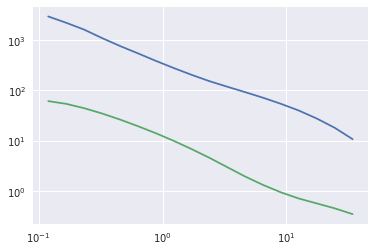

In [33]:
plt.plot(emu.scale_bin_centers, true_data[0])
plt.plot(emu.scale_bin_centers, true_data[1])

plt.loglog();

In [34]:
rbc = emu.scale_bin_centers#[-len(emu.scale_bin_centers):]

In [35]:
cov = f['cov'][()]
yerr = np.sqrt(np.diag(cov)).reshape((len(emus), -1))

In [36]:
true_data[0]

array([2935.62101263, 2199.73812339, 1610.56999143, 1095.0233464 ,
        762.76450704,  545.74623762,  386.9947355 ,  278.84355574,
        204.21184534,  152.72886374,  118.41331633,   92.43037572,
         71.55978193,   54.16238994,   39.83492178,   27.67886448,
         18.14391132,   10.77955277])

In [37]:
cov_mean = np.array([7407.57577016, 5860.73332887, 4562.57221101, 3528.4855154 ,
       2653.86635206, 1942.18765577, 1375.70010706,  920.94666884,
        574.1329663 ,  334.4338443 ,  189.53636194,  118.15514169,
         84.2912142 ,   62.74489775,   45.52641089,   31.41342237,
         20.19772416,   11.76164792])

[]

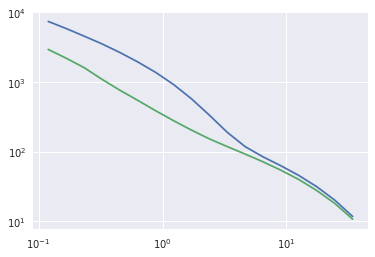

In [38]:
plt.plot(rbc, cov_mean, label = 'Cov Mean')
plt.plot(rbc, true_data[0], label = 'Data')
plt.loglog()

In [39]:
yerr[0]/true_data[0]

array([0.26337579, 0.24147407, 0.22054662, 0.23646183, 0.24008524,
       0.23598936, 0.22451181, 0.20940558, 0.19161107, 0.1737812 ,
       0.14149042, 0.11849034, 0.11751371, 0.12195797, 0.12095231,
       0.12207145, 0.13390343, 0.14898932])

In [40]:
rbc

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [41]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

In [42]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)

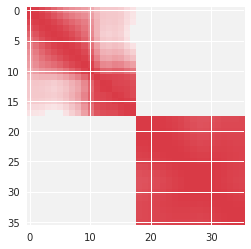

In [43]:
plt.imshow(cov_to_corr(cov ) , cmap=cmap, vmin = -1)

In [44]:
(true_data[1]/(10**emus[1].emulate_wrt_r(true_param_dict).squeeze() ) )

array([0.7030159 , 0.76411004, 0.81220416, 0.8440853 , 0.86642588,
       0.88315011, 0.90258536, 0.92229306, 0.94242922, 0.96428241,
       0.95658734, 0.92355189, 0.88612104, 0.84445419, 0.82558525,
       0.8336265 , 0.84987407, 0.85162289])

In [45]:
true_data

array([[2.93562101e+03, 2.19973812e+03, 1.61056999e+03, 1.09502335e+03,
        7.62764507e+02, 5.45746238e+02, 3.86994735e+02, 2.78843556e+02,
        2.04211845e+02, 1.52728864e+02, 1.18413316e+02, 9.24303757e+01,
        7.15597819e+01, 5.41623899e+01, 3.98349218e+01, 2.76788645e+01,
        1.81439113e+01, 1.07795528e+01],
       [6.13838047e+01, 5.41647113e+01, 4.45032949e+01, 3.49041635e+01,
        2.65066958e+01, 1.95906409e+01, 1.41990494e+01, 1.00279021e+01,
        6.87089415e+00, 4.61351576e+00, 2.99906991e+00, 1.95596467e+00,
        1.33210389e+00, 9.49130884e-01, 7.16198774e-01, 5.72940697e-01,
        4.57718895e-01, 3.51544906e-01]])

In [46]:
true_param_dict

{'H0': 67.77,
 'Neff': 3.046,
 'alpha': 1.083,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.2,
 'mean_occupation_centrals_assembias_param1': 0.0,
 'mean_occupation_satellites_assembias_param1': 0.0,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'sigma_logM': 0.2,
 'w0': -1.0}

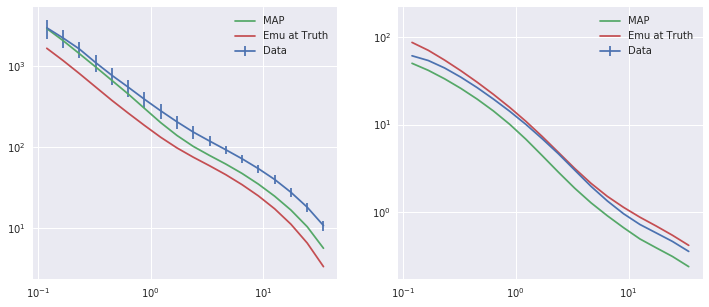

In [47]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, true_data[i], yerr=yerr[i], label = 'Data')
    plt.plot(rbc, 10**MAP_pred[i], label = 'MAP')
    plt.plot(rbc, 10**true_pred, label = 'Emu at Truth')

    plt.loglog()
    plt.legend(loc='best')
plt.show();

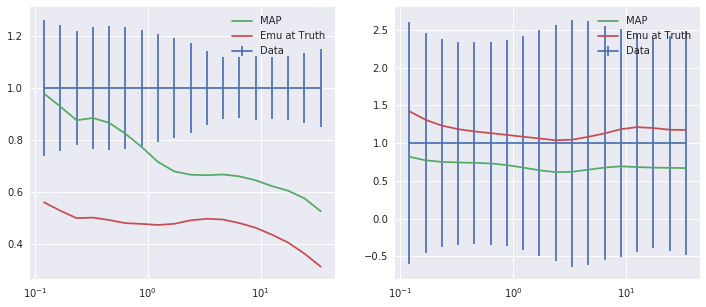

In [48]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    plt.plot(rbc, (10**MAP_pred[i])/true_data[i], label = 'MAP')
    plt.plot(rbc, (10**true_pred)/true_data[i], label = 'Emu at Truth')
    plt.legend(loc='best')
    plt.xscale('log')
plt.show();

In [49]:
emu.obs

'ds'

In [50]:
rbc

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [51]:
npart_aemulus = 1400**3
npart_mdpl2 = 3840**3

downsample_factor = 1e-2
npart_aemulus_ds = npart_aemulus*downsample_factor
print npart_aemulus_ds, npart_aemulus_ds/npart_mdpl2

27440000.0 0.000484607837818


In [52]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8',
       'mean_occupation_centrals_assembias_param1', 'logM0', 'sigma_logM',
       'mean_occupation_satellites_assembias_param1', 'logM1', 'alpha',
       'conc_gal_bias'], dtype='|S43')

In [53]:
true_pred = np.hstack([emu.emulate_wrt_r(true_param_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
true_pred = true_pred.reshape((len(emus), -1))

In [54]:
rmin_idxs = rbc > rmin

In [55]:
cov_rmin_idxs = np.r_[rmin_idxs, rmin_idxs]

In [56]:
print 'True Red. Chi2'
R = (10**true_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

True Red. Chi2
3.724139786822497


In [57]:
print 'Map Red. Chi2'
R = (10**MAP_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

Map Red. Chi2
1.9758278260129882


In [58]:
N = 10
cmap = sns.color_palette("BrBG_d", N)

In [59]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

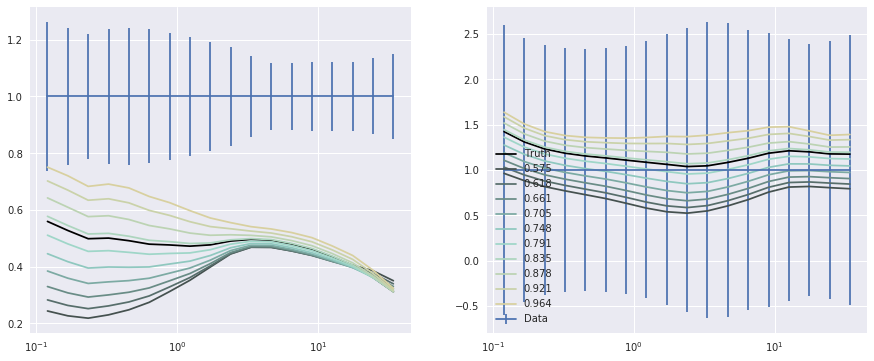

In [60]:
fig = plt.figure(figsize=(15,6))
varied_pname = 'sigma8'
lower, upper = emu.get_param_bounds(varied_pname)

for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.plot(rbc, (10**pred)/true_data[i], label = 'Truth', color = 'k')    

    plt.xscale('log')
    
for c, val in zip(cmap, np.linspace(lower, upper, N) ):
    param_dict = true_param_dict.copy()
    param_dict[varied_pname] = val

    for i in xrange(len(emus)):
        plt.subplot(1,2,i+1)
        pred = emus[i].emulate_wrt_r(param_dict).squeeze()
        plt.plot(rbc, (10**pred)/true_data[i], label = '%.3f'%val, color = c)
    
plt.legend(loc='best')
plt.show();

In [61]:
emu_avg = 10**(emus[1].y.mean(axis=(0,1))+emu._y_mean)

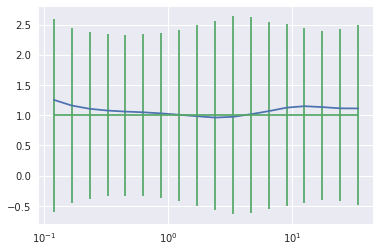

In [62]:
plt.plot(rbc, emu_avg/true_data[1])
plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i])
plt.xscale('log')

In [64]:
cat.load(1.0, HOD='zheng07', particles=True)

most_recent_01_1_particle_2.00


In [67]:
from scipy.optimize import minimize_scalar
def add_logMmin(hod_params, cat, nd = 5e-4):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params, min_ptcl=20) - nd)**2

    res = minimize_scalar(func, bounds = (12,16), args = (hod_params,),\
                          options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [68]:
add_logMmin(hod_params, cat)

logMmin 13.07088948554348


In [69]:
cat.populate(hod_params)

In [70]:
r_bins = np.logspace(-1, 1.6, 19)

In [71]:
print (r_bins[1:]+r_bins[:-1])/2.0

[ 0.11972916  0.16697228  0.23285675  0.32473812  0.45287435  0.63157098
  0.88077831  1.22831868  1.71299265  2.38891086  3.33153507  4.646103
  6.47937742  9.03603121 12.60149776 17.5738377  24.50817968 34.17869685]


In [72]:
emu.scale_bin_centers

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [73]:
wp = cat.calc_wp(r_bins)

In [74]:
ds = cat.calc_ds(r_bins)

In [75]:
np.save('/u/ki/swmclau2/Git/pearce/bin/mock_measurements/HOD4mock_wp.npy', wp)
np.save('/u/ki/swmclau2/Git/pearce/bin/mock_measurements/HOD4mock_ds.npy', ds)

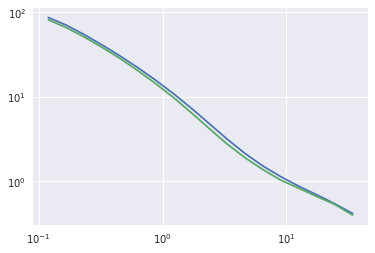

In [81]:
plt.plot(emu.scale_bin_centers, 10**true_pred[1] )
plt.plot(emu.scale_bin_centers, ds)
plt.loglog();